# Гераськин Ярослав

**Общая информация**
**Срок сдачи:** 18 октября 2017, 06:00 <br/>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.stats import mode
from functools import partial
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%load_ext pycodestyle_magic

/home/rickya/anaconda3/lib/python3.7/site-packages/pycodestyle.py:113: FutureWarning: Possible nested set at position 1
  EXTRANEOUS_WHITESPACE_REGEX = re.compile(r'[[({] | []}),;:]')


In [3]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase,
                             KNeighborsMixin,
                             SupervisedIntegerMixin,
                             ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self._n_neighbors = n_neighbors
        self._algorithm = algorithm

    def fit(self, X, y):
        self._scaler = MinMaxScaler()
        self._X = self._scaler.fit_transform(X.astype(np.float64))
        self._y = y.astype(np.int32)
        self._n_classes = np.unique(self._y).shape[0]

        if self._algorithm == 'brute':
            self._norm2 = (self._X ** 2).sum(axis=1)
        elif self._algorithm == 'kd_tree':
            self._kd = KDTree(self._X)
        else:
            raise ValueError('algorithm name should be "brute" or "kd_tree"')

    def _dist(self, X):
        norm2 = (X ** 2).sum(axis=1)

        dist2 = -2 * X.dot(self._X.T)
        dist2 += norm2[:, np.newaxis]
        dist2 += self._norm2[np.newaxis, :]

        return dist2

    def _extract_neighbors(self, X):
        X = self._scaler.transform(X.astype(np.float64))
        if self._algorithm == 'brute':
            bs = 1000
            ret = np.empty((X.shape[0], self._n_neighbors), np.int32)
            for i in range(0, X.shape[0], bs):
                dist2 = self._dist(X[i:i + bs])

                ids = np.argpartition(
                    dist2,
                    self._n_neighbors
                )[:, :self._n_neighbors]

                ret[i:i + bs] = self._y[ids]
            return ret
        elif self._algorithm == 'kd_tree':
            ids = self._kd.query(X, k=self._n_neighbors, return_distance=False)
            return self._y[ids]
        else:
            raise ValueError('algorithm name should be "brute" or "kd_tree"')

    def predict(self, X):
        neighbors = self._extract_neighbors(X)
        return mode(neighbors, axis=1)[0].ravel()

    def predict_proba(self, X):
        neighbors = self._extract_neighbors(X)
        counter = partial(np.bincount, minlength=self._n_classes)
        return np.apply_along_axis(counter, 1, neighbors) / self._n_neighbors

    def score(self, X, y):
        y = y.astype(np.int32)
        return (self.predict(X) == y).astype(np.float64).mean()

**IRIS**

In [4]:
seed = 4124

In [5]:
iris = datasets.load_iris()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target, random_state=seed)

In [7]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 2.35 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3.52 ms, sys: 0 ns, total: 3.52 ms
Wall time: 2.3 ms


In [10]:
%time clf.predict(X_test)

CPU times: user 2.99 ms, sys: 0 ns, total: 2.99 ms
Wall time: 2.55 ms


array([2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 4.08 ms, sys: 7 µs, total: 4.09 ms
Wall time: 19.3 ms


array([1, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 2], dtype=int32)

In [12]:
%time a = clf.predict_proba(X_test)

CPU times: user 858 µs, sys: 79 µs, total: 937 µs
Wall time: 673 µs


In [13]:
%time b = my_clf.predict_proba(X_test)

CPU times: user 2.04 ms, sys: 117 µs, total: 2.16 ms
Wall time: 1.32 ms


In [14]:
clf.score(X_test, y_test)

0.8666666666666667

In [15]:
my_clf.score(X_test, y_test)

0.9333333333333333

Задание 3

Max score: 0.9333333333333333, 2 neighbors


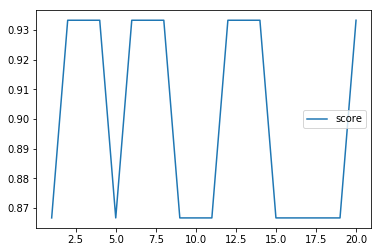

In [16]:
n, best = 0, 0
scores = []

for k in range(1, 21):
    clf = MyKNeighborsClassifier(k)
    clf.fit(X_train, y_train)

    score = clf.score(X_test, y_test)
    scores.append(score)
    
    if best < score:
        n, best = k, score

print('Max score: {}, {} neighbors'.format(best, n))

plt.plot(range(1, 21), scores, label='score')
plt.legend();

**MNIST**

In [17]:
mnist = fetch_mldata('MNIST original')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, stratify=mnist.target)

In [19]:
X_train.shape, X_test.shape

((63000, 784), (7000, 784))

In [20]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [21]:
%time clf.fit(X_train, y_train)

CPU times: user 38.9 s, sys: 191 ms, total: 39.1 s
Wall time: 39 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [22]:
%time my_clf.fit(X_train, y_train)

CPU times: user 2.47 s, sys: 1.38 s, total: 3.85 s
Wall time: 1.21 s


In [23]:
%time clf.predict(X_test)

CPU times: user 11min 54s, sys: 107 ms, total: 11min 54s
Wall time: 11min 54s


array([3., 4., 7., ..., 7., 1., 7.])

In [24]:
%time my_clf.predict(X_test)

CPU times: user 36.3 s, sys: 2.1 s, total: 38.4 s
Wall time: 11.6 s


array([3, 4, 7, ..., 7, 1, 7], dtype=int32)

In [25]:
%time clf.predict_proba(X_test)

CPU times: user 10min 26s, sys: 80 ms, total: 10min 26s
Wall time: 10min 26s


array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 1. , 0. , 0. ]])

In [26]:
%time my_clf.predict_proba(X_test)

CPU times: user 38.5 s, sys: 2.06 s, total: 40.6 s
Wall time: 12.3 s


array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 1. , 0. , 0. ]])

In [27]:
clf.score(X_test, y_test)

0.9674285714285714

In [28]:
my_clf.score(X_test, y_test)

0.9674285714285714

Задание 4

In [29]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [31]:
%time clf.fit(X_train, y_train)

CPU times: user 31.4 s, sys: 164 ms, total: 31.5 s
Wall time: 31.5 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [32]:
%time my_clf.fit(X_train, y_train)

CPU times: user 40.3 s, sys: 1.11 s, total: 41.4 s
Wall time: 39.2 s


In [33]:
%time clf.predict(X_test)

CPU times: user 1min 12s, sys: 9 µs, total: 1min 12s
Wall time: 1min 12s


array([3., 5., 4., 7., 3., 1., 5., 0., 0., 9., 9., 0., 2., 6., 9., 7., 6.,
       2., 5., 4., 2., 2., 2., 4., 4., 4., 9., 0., 8., 3., 9., 3., 9., 1.,
       3., 3., 4., 2., 8., 4., 8., 6., 9., 5., 5., 7., 5., 5., 1., 3., 5.,
       1., 1., 8., 6., 8., 5., 1., 4., 3., 1., 5., 4., 9., 1., 3., 0., 7.,
       7., 4., 5., 1., 5., 6., 9., 1., 0., 0., 9., 7., 2., 0., 3., 6., 0.,
       5., 7., 7., 3., 7., 5., 7., 3., 0., 6., 3., 1., 5., 2., 4., 2., 5.,
       7., 0., 2., 0., 4., 0., 4., 5., 0., 6., 0., 1., 9., 1., 7., 6., 3.,
       6., 1., 2., 1., 9., 7., 4., 7., 1., 6., 9., 8., 6., 8., 4., 1., 8.,
       6., 8., 9., 1., 3., 6., 3., 3., 8., 0., 4., 2., 7., 7., 7., 1., 5.,
       8., 9., 6., 6., 9., 0., 7., 9., 5., 4., 6., 6., 1., 8., 0., 9., 1.,
       0., 5., 0., 6., 0., 7., 7., 5., 8., 1., 8., 9., 9., 0., 2., 5., 7.,
       1., 6., 0., 7., 4., 6., 8., 3., 6., 7., 7., 7., 3., 9., 5., 4., 1.,
       1., 9., 0., 8., 6., 7., 0., 2., 7., 5., 3., 3., 8., 4., 6., 9., 7.,
       2., 2., 5., 7., 2.

In [34]:
%time my_clf.predict(X_test)

CPU times: user 1min 1s, sys: 20 ms, total: 1min 1s
Wall time: 1min


array([3, 5, 4, 7, 3, 1, 5, 0, 0, 9, 9, 0, 2, 6, 9, 7, 6, 2, 5, 4, 2, 2,
       2, 4, 4, 4, 9, 0, 8, 3, 9, 3, 9, 1, 3, 3, 4, 2, 8, 4, 8, 6, 9, 5,
       5, 7, 5, 5, 1, 3, 5, 1, 1, 8, 6, 8, 5, 1, 4, 3, 1, 5, 4, 9, 1, 3,
       0, 7, 7, 4, 5, 1, 5, 6, 9, 1, 0, 0, 9, 7, 2, 0, 3, 6, 0, 5, 7, 7,
       3, 7, 5, 7, 3, 0, 6, 3, 1, 5, 2, 4, 2, 5, 7, 0, 2, 0, 4, 0, 4, 5,
       0, 6, 0, 1, 9, 1, 7, 6, 3, 6, 1, 2, 1, 9, 7, 4, 7, 1, 6, 9, 8, 6,
       8, 4, 1, 8, 6, 8, 9, 1, 3, 6, 3, 3, 8, 0, 4, 2, 7, 7, 7, 1, 5, 8,
       9, 6, 6, 9, 0, 7, 9, 5, 4, 6, 6, 1, 8, 0, 9, 1, 0, 5, 0, 6, 0, 7,
       7, 5, 8, 1, 8, 9, 9, 0, 2, 5, 7, 1, 6, 0, 7, 4, 6, 8, 3, 6, 7, 7,
       7, 3, 9, 5, 4, 1, 1, 9, 0, 8, 6, 7, 0, 2, 7, 5, 3, 3, 8, 4, 6, 9,
       7, 2, 2, 5, 7, 2, 8, 1, 4, 3, 1, 6, 6, 1, 3, 8, 2, 2, 4, 8, 0, 2,
       4, 3, 9, 4, 9, 0, 8, 0, 0, 8, 9, 7, 3, 0, 7, 5, 0, 0, 6, 3, 6, 1,
       7, 6, 1, 6, 0, 1, 3, 7, 4, 7, 8, 8, 3, 1, 3, 6, 6, 9, 3, 2, 0, 3,
       5, 6, 7, 0, 2, 8, 7, 2, 7, 7, 8, 2, 5, 9, 4,

In [35]:
%time clf.predict_proba(X_test)

CPU times: user 1min 10s, sys: 16 ms, total: 1min 10s
Wall time: 1min 10s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [36]:
%time my_clf.predict_proba(X_test)

CPU times: user 59.5 s, sys: 48 ms, total: 59.5 s
Wall time: 58.9 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [37]:
clf.score(X_test, y_test)

0.9685714285714285

In [38]:
my_clf.score(X_test, y_test)

0.9685714285714285

Задание 5

seaborn - библиотека для визуализации данных<br/>
matplotlib - библиотека для визуализации данных<br/>
train_test_split - разбивает данные на тренеровочную и тестовую части<br/>
Pipeline (from sklearn.pipeline import Pipeline) - класс, позволяющий последовательно обрабатывать данные (например PCA + KNN)<br/>
StandardScaler (from sklearn.preprocessing import StandardScaler) - нормирует данные в отрезок (-1, 1) так, что mean=0, std=1<br/>
ClassifierMixin - миксинг для классификаторов sklearn<br/>
NeighborsBase - класс для оценок ближайших соседей<br/>
KNeighborsMixin - миксинг для поиска к соседей<br/>
SupervisedIntegerMixin - миксинг для обучения на данных (X, y)